In [58]:
# import libraries
import pandas as pd
import networkx as nx
from pyvis.network import Network
import numpy as np
import matplotlib.pyplot as plt

# Load Data and Create Network

In [4]:
# now let's iterate through our amicus briefs and store the lexisCite, position, and amicus name
# data from https://amicispace.ucmerced.edu/data
amicus_briefs_csv = pd.read_csv("amicus_briefs.csv", encoding="latin")
amicus_briefs_csv = amicus_briefs_csv[["LexisCite", "Position", "AmicusName"]]
amicus_briefs_csv.head(5)

,LexisCite,Position,AmicusName
0,1953 U.S. LEXIS 2673,1,SECURITIES AND EXCHANGE COMMISSION
1,1953 U.S. LEXIS 2680,2,BOSTON AMERICAN LEAGUE BASE BALL COMPANY
2,1954 U.S. LEXIS 2094,1,AMERICAN FEDERATION OF TEACHERS
3,1954 U.S. LEXIS 2094,1,UNITED STATES
4,1954 U.S. LEXIS 2094,1,AMERICAN JEWISH CONGRESS


In [34]:
# some perfect duplicates -- drop?
amicus_briefs_csv.duplicated().mean()

0.007130397137654863

In [36]:
# drop perfect duplicates
amicus_briefs_csv = amicus_briefs_csv.drop_duplicates()

In [5]:
# position variable in amicus briefs
# = 1 if the brief argues the lower court decision should be reversed
# = 2 if lower court decision should be affirmed
# = 3 if the brief explicitly does not adopt a position or the position is unclear
amicus_briefs_csv["Position"].value_counts().sort_index()

Position
1    37158
2    39315
3     2064
Name: count, dtype: int64

In [6]:
amicus_briefs_csv["Position"].isna().mean()  # no missing values!

0.0

In [7]:
# let's now get the justices and their votes for each case (identified by LexisCite and caseName)
# data from http://scdb.wustl.edu/documentation.php
justices_csv = pd.read_csv("justices.csv", encoding="latin")
justices_csv = justices_csv[
    [
        "lexisCite",
        "justiceName",
        "vote",
        "caseName",
        "caseDisposition",
        "lcDispositionDirection",
        "direction",
    ]
]
justices_csv.head(5)

C:\Users\Jennah\AppData\Local\Temp\ipykernel_5664\61716743.py:3: DtypeWarning: Columns (6,16) have mixed types. Specify dtype option on import or set low_memory=False.
  justices_csv = pd.read_csv("justices.csv", encoding="latin")


,lexisCite,justiceName,vote,caseName,caseDisposition,lcDispositionDirection,direction
0,1946 U.S. LEXIS 1724,HHBurton,2.0,HALLIBURTON OIL WELL CEMENTING CO. v. WALKER e...,3.0,1.0,1.0
1,1946 U.S. LEXIS 1724,RHJackson,1.0,HALLIBURTON OIL WELL CEMENTING CO. v. WALKER e...,3.0,1.0,2.0
2,1946 U.S. LEXIS 1724,WODouglas,1.0,HALLIBURTON OIL WELL CEMENTING CO. v. WALKER e...,3.0,1.0,2.0
3,1946 U.S. LEXIS 1724,FFrankfurter,4.0,HALLIBURTON OIL WELL CEMENTING CO. v. WALKER e...,3.0,1.0,2.0
4,1946 U.S. LEXIS 1724,SFReed,1.0,HALLIBURTON OIL WELL CEMENTING CO. v. WALKER e...,3.0,1.0,2.0


In [8]:
# drop perfect duplicates
justices_csv = justices_csv.drop_duplicates()

In [9]:
# note the values of votes:
# Values:
# 1	voted with majority or plurality
# 2	dissent
# 3	regular concurrence
# 4	special concurrence
# 5	judgment of the Court
# 6	dissent from a denial or dismissal of certiorari , or dissent from summary affirmation of an appeal
# 7	jurisdictional dissent
# 8	justice participated in an equally divided vote
justices_csv["vote"].value_counts().sort_index()

vote
1.0    57671
2.0    14056
3.0     3039
4.0     3627
5.0      256
6.0       20
7.0      390
8.0      924
Name: count, dtype: int64

In [10]:
justices_csv["caseName"].unique().shape[0]

8907

In [11]:
justices_csv[
    "vote"
].isna().mean()  # votes are missing in about 2% of cases -- should we drop these?

0.024680819930005975

In [12]:
# direction is the "Direction of the Individual Justice's Votes"
# 1 = conservative
# 2 = liberal
justices_csv["direction"].value_counts().sort_index()

direction
1.0    36635
2.0    40699
Name: count, dtype: int64

In [13]:
#  A missing value code indicates that the decisionDirection was unspecifiable or that that justice did not participate.
justices_csv[
    "direction"
].isna().mean()  # direction is missing in about 5% of justice/case combinations

0.05698294048069067

In [14]:
justices_csv[["justiceName", "lexisCite"]].value_counts()  # why are there duplicates?

justiceName  lexisCite           
WODouglas    1974 U.S. LEXIS 102     2
SFReed       1955 U.S. LEXIS 1542    1
             1955 U.S. LEXIS 602     1
             1955 U.S. LEXIS 601     1
             1955 U.S. LEXIS 37      1
                                    ..
HHBurton     1948 U.S. LEXIS 2110    1
             1948 U.S. LEXIS 2086    1
             1948 U.S. LEXIS 2085    1
             1948 U.S. LEXIS 2084    1
WODouglas    1975 U.S. LEXIS 93      1
Name: count, Length: 82006, dtype: int64

In [15]:
# drop case with contradictory votes or check online to corroborate?
justices_csv[
    justices_csv[["justiceName", "lexisCite"]].duplicated(keep=False)
].sort_values(["lexisCite", "justiceName"])

,lexisCite,justiceName,vote,caseName,caseDisposition,lcDispositionDirection,direction
33240,1974 U.S. LEXIS 102,WODouglas,2.0,MISSISSIPPI v. ARKANSAS,NaN,NaN,NaN
33249,1974 U.S. LEXIS 102,WODouglas,1.0,MISSISSIPPI v. ARKANSAS,NaN,NaN,NaN


In [16]:
# for final case decision:
# 1	stay, petition, or motion granted
# 2	affirmed (includes modified)
# 3	reversed
# 4	reversed and remanded
# 5	vacated and remanded
# 6	affirmed and reversed (or vacated) in part
# 7	affirmed and reversed (or vacated) in part and remanded
# 8	vacated
# 9	petition denied or appeal dismissed
# 10	certification to or from a lower court
# 11	no disposition

# do we want to drop any of these where the case disposition seems like it would be tricky...
# or does it matter less because we care mostly about judge voting behavior?
justices_csv["caseDisposition"].value_counts().sort_index()

caseDisposition
1.0       421
2.0     24302
3.0     17954
4.0     22277
5.0     10045
6.0       683
7.0      1508
8.0       303
9.0      3204
10.0      116
11.0        9
Name: count, dtype: int64

In [17]:
justices_csv["caseDisposition"].isna().mean()  # around 1% are missing case disposition

0.014449985976806858

## Create Dictionary for Generating Network

In [18]:
# for simplicity, we want the final form factor to be a dictionary as it's easier to parse and find information
# let's first convert the amicus briefs into a dictionary with one key per docket
# each docket will have all the amicus briefs with the organization names and their positions

amici_data = {}

for _, brief_row in amicus_briefs_csv.iterrows():
    lexis_cite = brief_row["LexisCite"]
    amicus_name = brief_row["AmicusName"]
    position = brief_row["Position"]

    if lexis_cite not in amici_data:
        amici_data[lexis_cite] = []

    amici_data[lexis_cite].append((amicus_name, position))

list(amici_data.items())[:3]

[('1953 U.S. LEXIS 2673', [('SECURITIES AND EXCHANGE COMMISSION', 1)]),
 ('1953 U.S. LEXIS 2680', [('BOSTON AMERICAN LEAGUE BASE BALL COMPANY', 2)]),
 ('1954 U.S. LEXIS 2094',
  [('AMERICAN FEDERATION OF TEACHERS', 1),
   ('UNITED STATES', 1),
   ('AMERICAN JEWISH CONGRESS', 1),
   ('AMERICAN VETERANS COMMITTEE', 1),
   ('AMERICAN ETHICAL UNION', 1),
   ('AMERICAN JEWISH COMMITTEE', 1),
   ('ANTI-DEFAMATION LEAGUE', 1),
   ('JAPANESE AMERICAN CITIZENS LEAGUE', 1),
   ('UNITARIAN FELLOWSHIP FOR SOCIAL JUSTICE', 1),
   ('AMERICAN CIVIL LIBERTIES UNION', 1),
   ('CONGRESS OF INDUSTRIAL ORGANIZATIONS', 1)])]

In [19]:
# let's also do this for the judges
justices_data = {}

for _, justice_row in justices_csv.iterrows():
    lexis_cite = justice_row["lexisCite"]
    justice_name = justice_row["justiceName"]
    case_name = justice_row["caseName"]
    vote = justice_row["vote"]
    disposition = justice_row["caseDisposition"]
    decisiondirection = justice_row["lcDispositionDirection"]
    direction = justice_row["direction"]

    if lexis_cite not in justices_data:
        justices_data[lexis_cite] = {
            "justices": [],
            "caseName": case_name,
            "decision": disposition,
            "decisiondirection": decisiondirection,
        }

    justices_data[lexis_cite]["justices"].append((justice_name, vote, direction))

list(justices_data.items())[:2]

[('1946 U.S. LEXIS 1724',
  {'justices': [('HHBurton', 2.0, 1.0),
    ('RHJackson', 1.0, 2.0),
    ('WODouglas', 1.0, 2.0),
    ('FFrankfurter', 4.0, 2.0),
    ('SFReed', 1.0, 2.0),
    ('HLBlack', 1.0, 2.0),
    ('WBRutledge', 1.0, 2.0),
    ('FMurphy', 1.0, 2.0),
    ('FMVinson', 1.0, 2.0)],
   'caseName': 'HALLIBURTON OIL WELL CEMENTING CO. v. WALKER et al., DOING BUSINESS AS DEPTHOGRAPH CO.',
   'decision': 3.0,
   'decisiondirection': 1.0}),
 ('1946 U.S. LEXIS 1725',
  {'justices': [('HHBurton', 1.0, 1.0),
    ('RHJackson', 2.0, 2.0),
    ('WODouglas', 1.0, 1.0),
    ('FFrankfurter', 1.0, 1.0),
    ('SFReed', 1.0, 1.0),
    ('HLBlack', 2.0, 2.0),
    ('WBRutledge', 4.0, 1.0),
    ('FMurphy', 2.0, 2.0),
    ('FMVinson', 1.0, 1.0)],
   'caseName': 'CLEVELAND v. UNITED STATES',
   'decision': 2.0,
   'decisiondirection': 1.0})]

In [20]:
# Now we can merge our dictionaries together to get a final pre-processed dictionary
preproc_data = {}

for lexis_cite, brief in amici_data.items():
    justices_found = justices_data[lexis_cite]

    # if we can't find the corresponding case, we'll skip this row
    if justices_found is None:
        continue

    preproc_data[lexis_cite] = {
        "case_name": justices_found["caseName"],
        "justices": justices_found["justices"],
        "case_decision": justices_found["decision"],
        "decisiondirection": justices_found["decisiondirection"],
        "amici": brief,
    }


list(preproc_data.items())[:2]

[('1953 U.S. LEXIS 2673',
  {'case_name': 'WILKO v. SWAN et al., DOING BUSINESS AS HAYDEN, STONE & CO., et al.',
   'justices': [('HLBlack', 1.0, 2.0),
    ('WODouglas', 1.0, 2.0),
    ('EWarren', 1.0, 2.0),
    ('TCClark', 1.0, 2.0),
    ('FFrankfurter', 2.0, 1.0),
    ('HHBurton', 1.0, 2.0),
    ('SFReed', 1.0, 2.0),
    ('SMinton', 2.0, 1.0),
    ('RHJackson', 3.0, 2.0)],
   'case_decision': 3.0,
   'decisiondirection': 1.0,
   'amici': [('SECURITIES AND EXCHANGE COMMISSION', 1)]}),
 ('1953 U.S. LEXIS 2680',
  {'case_name': 'TOOLSON v. NEW YORK YANKEES, INC. et al.',
   'justices': [('HLBlack', 1.0, 1.0),
    ('WODouglas', 1.0, 1.0),
    ('EWarren', 1.0, 1.0),
    ('TCClark', 1.0, 1.0),
    ('FFrankfurter', 1.0, 1.0),
    ('HHBurton', 2.0, 2.0),
    ('SFReed', 2.0, 2.0),
    ('SMinton', 1.0, 1.0),
    ('RHJackson', 1.0, 1.0)],
   'case_decision': 2.0,
   'decisiondirection': 1.0,
   'amici': [('BOSTON AMERICAN LEAGUE BASE BALL COMPANY', 2)]})]

In [21]:
# let's make a function to determine if the judges agreed with the amicus brief
# here we need to determine whether the judge followed the amicus decision

# for amicus brief position:
# Indicates the position on the case expressed by the amicus brief.
# = 1 if the brief argues the lower court decision should be reversed,
# = 2 if lower court decision should be affirmed,
# = 3 if the brief explicitly does not adopt a position or the position is unclear.

# for final case decision:
# 1	stay, petition, or motion granted
# 2	affirmed (includes modified)
# 3	reversed
# 4	reversed and remanded
# 5	vacated and remanded
# 6	affirmed and reversed (or vacated) in part
# 7	affirmed and reversed (or vacated) in part and remanded
# 8	vacated
# 9	petition denied or appeal dismissed
# 10 certification to or from a lower court
# 11 no disposition

# for justice vote:
# 1	voted with majority or plurality
# 2	dissent
# 3	regular concurrence
# 4	special concurrence
# 5	judgment of the Court
# 6	dissent from a denial or dismissal of certiorari , or dissent from summary affirmation of an appeal
# 7	jurisdictional dissent
# 8	justice participated in an equally divided vote


def judgeAgreesWithAmicus(brief_position, case_decision, justice_vote):
    # if we have any invalid values, let's remove this scenario
    try:
        position, decision, vote = (
            int(brief_position),
            int(case_decision),
            int(justice_vote),
        )
    except:
        return 2

    # agrees with amicus brief for reversing lower court decision
    if position == 1 and (decision == 3 or decision == 4) and vote == 1:
        return 1

    # disagrees with amicus brief for reversing lower court decision
    if position == 1 and (decision == 3 or decision == 4) and vote == 2:
        return 0

    # agrees with amicus brief for affirming lower court decision
    if position == 2 and (decision == 2) and vote == 1:
        return 1

    # disagrees with amicus brief for affirming lower court decision
    if position == 2 and (decision == 2) and vote == 2:
        return 0

    # invalid scenario
    return 2

In [22]:
# make a function for determining ideological agreement
# is this the same as the previous function?
def amicusDirection(brief_position, case_decision, case_direction):
    """
    Determines whether there is ideological agremenet between judge and amicus.
    """
    # if we have any invalid values, let's remove this scenario
    try:
        position, decision, direction = (
            int(brief_position),
            int(case_decision),
            int(case_direction),
        )
    except:
        return 99

    # also invalid if direction is unspecifiable
    if direction == 3:
        return 99

    # case where brief argues the lower court decision should be reversed
    # and decision is (3) reversed, (4) reversed and remanded
    # direction of amicus brief should match case direction
    if position == 1 and (decision in [3, 4, 5, 8, 9]):
        return direction
    # argue lower court decision should be affirmed
    # and decision is (2) affirmed (includes modified)
    # -- note: should this also include (1)?
    elif position == 2 and (decision in [1, 2]):
        return direction
    # if the position is to reverse
    # and decision is (2) affirmed (includes modified)
    elif position == 1 and (decision in [1, 2]):
        return 1 if direction == 2 else 1
    # if the position is to reverse
    # and decision is (2) affirmed (includes modified)
    elif position == 2 and (decision in [3, 4, 5, 8, 9]):
        return 1 if direction == 2 else 1
    else:
        return 99

In [23]:
# Let's construct a graph now
# We make an assumption that the judges and amicus organizations have no overlapping names

G = nx.MultiDiGraph()

# We also are going to keep track of the justices and amici that make the final graph
final_justices = set()
final_amici = set()
final_cases = set()
final_cases_per_justice = {}

for lexis_cite, docket in preproc_data.items():
    for amicus in docket["amici"]:
        # identify the ideological direction of the amicus brief based on its relationship with the disposition
        # and the disposition direction
        amicus_direction = amicusDirection(
            amicus[1], docket["case_decision"], docket["decisiondirection"]
        )
        for justice in docket["justices"]:
            # identify whether the judge agrees with the amicus
            # 0 = disagree, 1 = agree, 2 = trash
            agreement = judgeAgreesWithAmicus(
                amicus[1], docket["case_decision"], justice[1]
            )
            # identify whether judge's opinion is conservative
            conservative_position = int(justice[2] == 1)
            ideological_agreement = int(justice[2] == amicus_direction)
            if agreement < 2:
                final_justices.add(justice[0])
                final_amici.add(amicus[0])
                final_cases.add(lexis_cite)

                if justice[0] not in final_cases_per_justice:
                    final_cases_per_justice[justice[0]] = set()
                final_cases_per_justice[justice[0]].add(lexis_cite)

                G.add_edge(
                    justice[0],
                    amicus[0],
                    caseName=docket["case_name"],
                    agreement=agreement,
                    ideological_agreement=ideological_agreement,
                    amicus_direction=amicus_direction,
                    judge_direction=justice[2],
                )

In [24]:
list(G.edges(data=True))[:5]

[('HLBlack',
  'SECURITIES AND EXCHANGE COMMISSION',
  {'caseName': 'WILKO v. SWAN et al., DOING BUSINESS AS HAYDEN, STONE & CO., et al.',
   'agreement': 1,
   'ideological_agreement': 0,
   'amicus_direction': 1,
   'judge_direction': 2.0}),
 ('HLBlack',
  'SECURITIES AND EXCHANGE COMMISSION',
  {'caseName': 'J. I. CASE CO. et al. v. BORAK',
   'agreement': 1,
   'ideological_agreement': 1,
   'amicus_direction': 2,
   'judge_direction': 2.0}),
 ('HLBlack',
  'SECURITIES AND EXCHANGE COMMISSION',
  {'caseName': 'TCHEREPNIN et al. v. KNIGHT et al.',
   'agreement': 1,
   'ideological_agreement': 0,
   'amicus_direction': 1,
   'judge_direction': 2.0}),
 ('HLBlack',
  'BOSTON AMERICAN LEAGUE BASE BALL COMPANY',
  {'caseName': 'TOOLSON v. NEW YORK YANKEES, INC. et al.',
   'agreement': 1,
   'ideological_agreement': 1,
   'amicus_direction': 1,
   'judge_direction': 1.0}),
 ('HLBlack',
  'MEMBER MUNICIPALITIES OF THE NATIONAL INSTITUTE OF MUNICIPAL LAW OFFICERS',
  {'caseName': 'PHILLIP

In [25]:
# Create a visualization of a mini-version of the graph

G_mini = nx.MultiDiGraph()

# going to use a counter so we can visualize faster
maxCount = 10  # Comment line out for full graph
counter = 0

for lexis_cite, docket in preproc_data.items():
    if counter >= maxCount:
        break
    for amicus in docket["amici"]:
        for justice in docket["justices"]:
            # 0 = disagree, 1 = agree, 2 = trash
            agreement = judgeAgreesWithAmicus(
                amicus[1], docket["case_decision"], justice[1]
            )
            if agreement < 2:
                G_mini.add_edge(
                    justice[0],
                    amicus[0],
                    caseName=docket["case_name"],
                    agreement=agreement,
                )
                counter += 1

net = Network(
    directed=True,
    select_menu=True,  # Show part 1 in the plot (optional)
    filter_menu=True,  # Show part 2 in the plot (optional)
)

net.show_buttons()  # Show part 3 in the plot (optional)
net.from_nx(G_mini)  # Create directly from nx graph
net.show("test.html")
print("open the test.html file created!!")

open the test.html file created!!


In [26]:
# Quick sanity check for the two graphs
agree = 0
disagree = 0
for edge in G.edges(data=True):
    if edge[2]["agreement"]:
        agree += 1
    else:
        disagree += 1

print("full graph")
print("agree:", agree, "\ndisagree:", disagree, "\ntotal:", agree + disagree)

agree = 0
disagree = 0
for edge in G_mini.edges(data=True):
    if edge[2]["agreement"]:
        agree += 1
    else:
        disagree += 1

print("\nmini graph")
print("agree:", agree, "\ndisagree:", disagree, "\ntotal:", agree + disagree)

full graph
agree: 194957 
disagree: 62677 
total: 257634

mini graph
agree: 13 
disagree: 4 
total: 17


In [39]:
# sanity check for our data

# number of judges
print("number of judges:", len(final_justices))

# number of amici organizations
print("number of amici:", len(final_amici))

# total number of amicus briefs
print("number of cases:", len(final_cases))

# number of cases per judge
cases_per_justice = {}

for justice in final_justices:
    cases_per_justice[justice] = len(final_cases_per_justice[justice])

# number of cases per amicus
cases_per_amicus = {}

for amicus in final_amici:
    cases_per_amicus[justice] = len(G.in_edges(amicus))

print("avg number of cases per judge:", np.mean(list(cases_per_justice.values())))
print("avg number of cases per amicus:", np.mean(list(cases_per_amicus.values())))

number of judges: 33
number of amici: 10426
number of cases: 2813
avg number of cases per judge: 664.1818181818181
avg number of cases per amicus: 16.0


## Plot distribution of filings across cases

In [52]:
# create dataframe for ease of data manipulation
df = pd.DataFrame.from_dict(preproc_data, orient='index')

In [56]:
df['num_amici'] = df['amici'].apply(lambda x: len(x))
df[['amici', 'num_amici']].head(5)

,amici,num_amici
1953 U.S. LEXIS 2673,"[(SECURITIES AND EXCHANGE COMMISSION, 1)]",1
1953 U.S. LEXIS 2680,"[(BOSTON AMERICAN LEAGUE BASE BALL COMPANY, 2)]",1
1954 U.S. LEXIS 2094,"[(AMERICAN FEDERATION OF TEACHERS, 1), (UNITED...",11
1954 U.S. LEXIS 2095,"[(AMERICAN FEDERATION OF TEACHERS, 1), (UNITED...",21
1954 U.S. LEXIS 2336,"[(SECURITIES AND EXCHANGE COMMISSION, 2)]",1


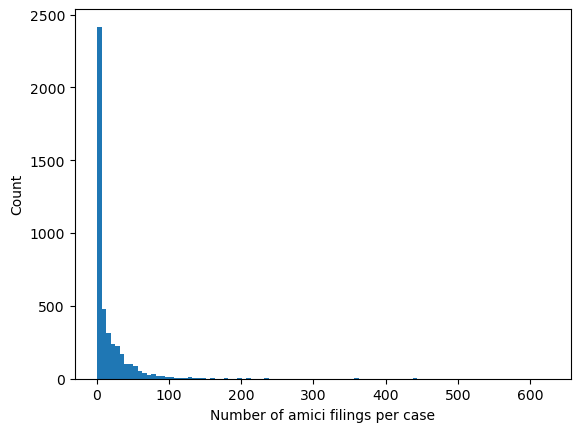

In [61]:

plt.hist(df['num_amici'], bins=100)
plt.ylabel('Count')
plt.xlabel('Number of amici filings per case');
